# Imports

In [1]:
import numpy as np
import pickle
from os import path

# Plotting
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Simulation and screening functions
from SEIR_viral_load_symptoms import *
from screening import *
# Plotting utilities from Samuel F. Way.
from util import *

# Color Scheme and Styles

These are just some helper functions to get the plots going

In [2]:
def fig_setup(nrows,ncols,w=6,h=4):
    fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(ncols*w,nrows*h))
    if nrows*ncols==1:
        return fig,axs
    else:
        return fig,axs.transpose().flatten()

In [3]:
def label(ax,x,y,string,color,loc,xoffset=0.01,yoffset=0.01):
    if loc=='NE':
        va='bottom'
        ha='left'
    if loc=='SW':
        xoffset *= -1
        yoffset *= -1
        va = 'top'
        ha = 'right'
    if loc=='NW':
        xoffset *= -1
        va = 'bottom'
        ha = 'right'
    if loc=='SE':
        yoffset *= -1
        va = 'top'
        ha = 'left'
    ax.text(x+xoffset,y+yoffset,string,color=color,fontsize=11,va=va,ha=ha)

In [4]:
grey = np.ones(3)*0.3
colors = np.array(['#e27396','#50c9ce','#98ce00','#166088','#590925'])
color_pcr = '#fcba03'
color_pcr_annot = '#ca9502'
color_ag = '#fc5e03'
# color_ag = '#73580d'

prev_colors = ['#0e3e58','#196d9a','#4fafe3','#a7d7f1'] #blues
ons_colors = ['','#3e0e58','#6d199a','#af4fe3','#d7a7f1'] #purps
dur_colors = ['#3e580e','#6d9a19','#afe34f','#d7f1a7'] #greens
Q_colors = ['#9a196d','#e34faf','#f1a7d7']

In [5]:
def key2lab(key):
    D,r,L,dur,ons,prob,cutoff = key
    if r==1:
        return ('no screening', False)
    part = int(100*(1-r))
    prev = int(100*prob)
    d2str = {0:'one-shot',1:'daily',2:'every 2 days',3:'every 3 days',7:'weekly'}
    if dur==0 and ons==0:
        lab = '{}% participation, {} PCR'.format(part, d2str[D])
        is_PCR = True
    else:
        if ons==0:
            onsstr = ''
        elif ons < 0:
            onsstr = str(ons)
        else:
            onsstr = '+'+str(ons)
        lab = '{}% participation, {}% sympt. prev., onset $t_{}{}$'.format(part,prev,'{PCR}',onsstr)
        is_PCR=False
    return lab,is_PCR

In [6]:
def plot_curve(ax,dat,key,color):
    lw=2
    D,r,L,dur,ons,prob,cutoff = key
    lab,is_pcr = key2lab(key)
    ls = '--' if is_pcr else '-'
    St,It,Rt,Qt,SQt,external,internal,ext_pre,int_pre,ODt,molt = dat
    N = St[0]+It[0]
    Pt = np.array(It)+np.array(Qt)+np.array(SQt)
    if cutoff<0.001:
        t = np.arange(180)
    else:
        t_cut = np.where(Pt/N>cutoff)[0][0]
        t = np.arange(180)-t_cut+1
    ax.plot(t,Pt/N,
            lw=lw,
            zorder=2,
            color=color,
            ls=ls,
            label=lab)

# Helpers

A quick SEIR helper function. It just parses the contents of a tuple and runs the SEIR code from the external .py files. 

In [7]:
def SEIR(key):
    N = 20000
    external_rate = 1/N
    se_sample = 0.9
    infectiousness_function=logproportional
    D,r,L,dur,ons,prob_anosmia,prev_cutoff = key
    if L==3:
        dt=1
    else:
        dt=0
    x = SEIRsimulation_suppression(
                        N,
                        external_rate,
                        dur,ons,prob_anosmia,
                        D,L,dt,
                        infectiousness_function,
                        prev_cutoff=prev_cutoff,
                        se_sample=se_sample,
                        refusal_rate=r,
                        asymptomatic=0.65,
                        R0=1.5,
                        cutoff=6,
                        I_init=0,
                        tmax=180,
                        calibration_mode=False)
    return x

# START Simulations

The following cells execute all the simulations shown in the paper and supplementary materials. 

In [55]:
kolors_supp = {}
keys_supp = []
plots_supp = {}

# No Control
prev_cutoff=0 
participation = 0
r = 1-participation
dur = 7
ons = -1
prob_anosmia = 0.9
D = 1
L = 3
key_noctrl = (D,r,L,dur,ons,prob_anosmia,prev_cutoff)
keys_supp.append(key_noctrl)
kolors_supp[key_noctrl] = [0.3,0.3,0.3]
plots_supp[key_noctrl] = []

###### PCR at 80% participation
D=7
prev_cutoff = 0
participation = 0.8
r = 1-participation
dur = 0
ons = 0
prob_anosmia = 0
L = 3
key7 = (D,r,L,dur,ons,prob_anosmia,prev_cutoff)
D=3
key3 = (D,r,L,dur,ons,prob_anosmia,prev_cutoff)
keys_supp.append(key7)
keys_supp.append(key3)
kolors_supp[key3] = color_pcr
kolors_supp[key7] = color_pcr
plots_supp[key3] = []
plots_supp[key7] = []

###### Ag at 80% participation
D=7
prev_cutoff = 0
participation = 0.8
r = 1-participation
dur = 0
ons = 0
prob_anosmia = 0
L=6
key7ag = (D,r,L,dur,ons,prob_anosmia,prev_cutoff)
D=3
key3ag = (D,r,L,dur,ons,prob_anosmia,prev_cutoff)
keys_supp.append(key7ag)
keys_supp.append(key3ag)
kolors_supp[key3ag] = color_ag
kolors_supp[key7ag] = color_ag
plots_supp[key3ag] = []
plots_supp[key7ag] = []

###### Anosmia at 80% participation (and 80% ability to participate) = 64% effective participation
part = 0.64
onsvals = [1,2,3,4]
durvals = [1,3,5,7]
Ds = [1,3,7]
prev_cutoff = 0
L=5
prev = 0.75

for ii,dur in enumerate(durvals):
    for jj,D in enumerate(Ds):
        if D==1:
            plots_supp[key3].append((ii,jj))
            plots_supp[key3ag].append((ii,jj))
        if D in [3,7]:
            plots_supp[key7].append((ii,jj))
            plots_supp[key7ag].append((ii,jj))
        plots_supp[key_noctrl].append((ii,jj))
        for kk,ons in enumerate(onsvals):
            key = (D,1-part,L,dur,ons,prev,prev_cutoff)
            keys_supp.append(key)
            kolors_supp[key] = ons_colors[ons]
            plots_supp[key] = [(ii,jj)]
            
keys_supp = list(set(keys_supp))
            
seeds_supp = []        
for idx,key in enumerate(keys_supp):
    seeds_supp.append(idx)

In [56]:
recompute_supp = False
if recompute_supp == True:
    sims_supp = {}
    for idx,key in enumerate(keys_supp):
        print(idx,len(keys_supp))
        sims_supp[key] = SEIR(key)
    with open('sims_supp.pkl','wb') as f:
            pickle.dump(sims_supp,f)
else:
    with open('sims_supp.pkl','rb') as f:
        sims_supp = pickle.load(f)
    for qq,key in enumerate(keys_supp):
        if key in sims_supp:
            continue
        else:
            print(qq,len(keys_supp))
            sims_supp[key] = SEIR(key)
    with open('sims_supp.pkl','wb') as f:
            pickle.dump(sims_supp,f)        

In [57]:
kolors = {}
keys = []
plots = {}

part = 0.64
ons = 2
dur = 7
prev_cutoff = 0
Ds = [3]
L = 5

# Prevalence
prevs = [0.25,0.5,0.75,0.9]
plot_idx=1
for D in Ds:
    for idx,prev in enumerate(prevs):
        key = (D,1-part,L,dur,ons,prev,prev_cutoff)
        keys.append(key)
        if (key in plots) and (plot_idx not in plots[key]):
            plots[key].append(plot_idx)
        else:
            plots[key] = [plot_idx]
        kolors[key] = prev_colors[idx]
        
# Onset
prev = 0.75
onsets = [1,2,3,4]
plot_idx=2
for D in Ds:
    for idx,ons in enumerate(onsets):
        key = (D,1-part,L,dur,ons,prev,prev_cutoff)
        keys.append(key)
        if (key in plots) and (plot_idx not in plots[key]):
            plots[key].append(plot_idx)
        else:
            plots[key] = [plot_idx]
        kolors[key] = ons_colors[ons]
        
# Duration
ons = 2
durs = 1,3,5,7
plot_idx=3
for D in Ds:
    for idx,dur in enumerate(durs):
        key = (D,1-part,L,dur,ons,prev,prev_cutoff)
        keys.append(key)
        if (key in plots) and (plot_idx not in plots[key]):
            plots[key].append(plot_idx)
        else:
            plots[key] = [plot_idx]
        kolors[key] = dur_colors[idx]

# Outbreak!
prev_cutoff = 0.02
ons = 2
durs = [7]
Ds = 1,3,7
plot_idx=4
for idx,D in enumerate(Ds):
    for dur in durs:
        key = (D,1-part,L,dur,ons,prev,prev_cutoff)
        keys.append(key)
        if (key in plots) and (plot_idx not in plots[key]):
            plots[key].append(4)
        else:
            plots[key] = [4]
        kolors[key] = Q_colors[idx]
        
# No Control
prev_cutoff=0 
participation = 0
r = 1-participation
dur = 7
ons = -1
prob_anosmia = 0.9
D = 1
L = 3

key = (D,r,L,dur,ons,prob_anosmia,prev_cutoff)
keys.append(key)
plots[key] = [1,2,3,111,117,121,127,131,137]
kolors[key] = [0.3,0.3,0.3]

prev_cutoff=0.02
key = (D,r,L,dur,ons,prob_anosmia,prev_cutoff)
keys.append(key)
plots[key] = [4]
kolors[key] = [0.3,0.3,0.3]


# PCR
D=7
prev_cutoff = 0
participation = 0.8
r = 1-participation
dur = 0
ons = 0
prob_anosmia = 0
L = 3
key = (D,r,L,dur,ons,prob_anosmia,prev_cutoff)
keys.append(key)
kolors[key] = color_pcr
plots[key] = [1,2,3,111,117,121,127,131,137]

prev_cutoff = 0.02
key = (D,r,L,dur,ons,prob_anosmia,prev_cutoff)
keys.append(key)
kolors[key] = color_pcr
plots[key] = [4]

# Rapid Antigen
D=7
prev_cutoff = 0
participation = 0.8
r = 1-participation
dur = 0
ons = 0
prob_anosmia = 0
L = 6
key = (D,r,L,dur,ons,prob_anosmia,prev_cutoff)
keys.append(key)
kolors[key] = color_ag
plots[key] = [1,2,3,111,117,121,127,131,137]

prev_cutoff = 0.02
key = (D,r,L,dur,ons,prob_anosmia,prev_cutoff)
keys.append(key)
kolors[key] = color_ag
plots[key] = [4]




#### SUP FIGS
part = 0.64
ons = 2
dur = 7
prev_cutoff = 0
L = 5

# Prevalence
prevs = [0.25,0.5,0.75,0.9]
plot_idx=111
Ds = [1]
for D in Ds:
    for idx,prev in enumerate(prevs):
        key = (D,1-part,L,dur,ons,prev,prev_cutoff)
        keys.append(key)
        if (key in plots) and (plot_idx not in plots[key]):
            plots[key].append(plot_idx)
        else:
            plots[key] = [plot_idx]
        kolors[key] = prev_colors[idx]
plot_idx=117
Ds=[7]
for D in Ds:
    for idx,prev in enumerate(prevs):
        key = (D,1-part,L,dur,ons,prev,prev_cutoff)
        keys.append(key)
        if (key in plots) and (plot_idx not in plots[key]):
            plots[key].append(plot_idx)
        else:
            plots[key] = [plot_idx]
        kolors[key] = prev_colors[idx]
        
# Onset
prev = 0.75
onsets = [1,2,3,4]
Ds=[1]
plot_idx=121
for D in Ds:
    for idx,ons in enumerate(onsets):
        key = (D,1-part,L,dur,ons,prev,prev_cutoff)
        keys.append(key)
        if (key in plots) and (plot_idx not in plots[key]):
            plots[key].append(plot_idx)
        else:
            plots[key] = [plot_idx]
        kolors[key] = ons_colors[ons]
Ds=[7]
plot_idx=127
for D in Ds:
    for idx,ons in enumerate(onsets):
        key = (D,1-part,L,dur,ons,prev,prev_cutoff)
        keys.append(key)
        if (key in plots) and (plot_idx not in plots[key]):
            plots[key].append(plot_idx)
        else:
            plots[key] = [plot_idx]
        kolors[key] = ons_colors[ons]
        
# Duration
ons = 2
durs = 1,3,5,7
plot_idx=103
Ds=[1]
plot_idx=131
for D in Ds:
    for idx,dur in enumerate(durs):
        key = (D,1-part,L,dur,ons,prev,prev_cutoff)
        keys.append(key)
        if (key in plots) and (plot_idx not in plots[key]):
            plots[key].append(plot_idx)
        else:
            plots[key] = [plot_idx]
        kolors[key] = dur_colors[idx]
Ds=[7]
plot_idx=137
for D in Ds:
    for idx,dur in enumerate(durs):
        key = (D,1-part,L,dur,ons,prev,prev_cutoff)
        keys.append(key)
        if (key in plots) and (plot_idx not in plots[key]):
            plots[key].append(plot_idx)
        else:
            plots[key] = [plot_idx]
        kolors[key] = dur_colors[idx]
        
        
# PCR Q3 for table
D=3
prev_cutoff = 0
participation = 0.8
r = 1-participation
dur = 0
ons = 0
prob_anosmia = 0
L = 3
key = (D,r,L,dur,ons,prob_anosmia,prev_cutoff)
keys.append(key)
kolors[key] = color_pcr
plots[key] = []

# Ag Q3 for table
D=3
prev_cutoff = 0
participation = 0.8
r = 1-participation
dur = 0
ons = 0
prob_anosmia = 0
L = 6
key = (D,r,L,dur,ons,prob_anosmia,prev_cutoff)
keys.append(key)
kolors[key] = color_ag
plots[key] = []

sims = {}

keys = list(set(keys))

## Choose whether to recompute all the simulations or just load

In [60]:
with open('sims.pkl','rb') as f:
    sims = pickle.load(f)
    
recompute_keys = False
if recompute_keys==True:
    sims = {}
    for qq,key in enumerate(keys):
        print(qq,len(keys))
        np.random.seed(seeds[key])
        sims[key] = SEIR(key)
    with open('sims.pkl','wb') as f:
        pickle.dump(sims,f)
else:
    for qq,key in enumerate(keys):
        if key in sims:
            continue
        else:
            print(qq,len(keys))
            np.random.seed(seeds[key])
            sims[key] = SEIR(key)
    with open('sims.pkl','wb') as f:
        pickle.dump(sims,f)

# END Simulations

------------------------

# Compute R Reduction Factors

In [8]:
is_recompute=False

np.random.seed(4)

onsvals = [1,2,3,4]
durvals = [1,3,5,7]
probs = [0.25,0.5,0.75,0.9]
Dvals = [1,3,7]
asymp = 0.65
n_samples=10000
keys_b = [('pcr'),('rapid_ag')]
for d in durvals:
    for p in probs:
        keys_b.append((d,p))
        
if is_recompute==True:
    impacts_logproportional = {}
    for key in keys_b:
        print('--',key)
        if key=='pcr':
            prob=0
            dur=1
            impacts_logproportional[key] = impact_population(logproportional,dur,onsvals,prob,Dvals,
                                                       asymptomatic=asymp,n_samples=n_samples,use_pcr='pcr')
        elif key=='rapid_ag':
            prob=0
            dur=1
            impacts_logproportional[key] = impact_population(logproportional,dur,onsvals,prob,Dvals,
                                                       asymptomatic=asymp,n_samples=n_samples,use_pcr='rapid_ag')
        else:
            dur = key[0]
            prob = key[1]
            impacts_logproportional[key] = impact_population(logproportional,
                                                          dur,onsvals,prob,Dvals,asymptomatic=asymp,n_samples=n_samples)
    with open('impacts_logproportional.pkl','wb') as f:
        pickle.dump(impacts_logproportional,f)
else:
    with open('impacts_logproportional.pkl','rb') as f:
        impacts_logproportional = pickle.load(f)
    # R_reduction_factor,test,self,notest,noself
    # array is onsvals x Dvals

# Table

In [62]:
table_keys = [
    (1, 0.36, 5, 7, 1, 0.75, 0),
    (3, 0.36, 5, 7, 1, 0.75, 0),
    (7, 0.36, 5, 7, 1, 0.75, 0),
    (3, 0.19999999999999996, 3, 0, 0, 0, 0),
    (7, 0.19999999999999996, 3, 0, 0, 0, 0),
    (3, 0.19999999999999996, 6, 0, 0, 0, 0),
    (7, 0.19999999999999996, 6, 0, 0, 0, 0)]


key = (7,0.75)
particip = 0.64
red_od = particip -  particip*impacts_logproportional[key][0][1,:]

particip = 0.8
key = 'pcr'
red_pcr = np.mean(particip - particip*impacts_logproportional[key][0],axis=0)

particip = 0.8
key = 'rapid_ag'
red_ag = np.mean(particip - particip*impacts_logproportional[key][0],axis=0)

D2idx = {1:0,3:1,7:2}

D2str = {1:'daily', 3:'every 3 days', 7:'weekly'}
with open('../figs/table_ons2.csv','w') as f:
    f.write('Test frequency,OD tests,PCR/Ag tests,Cost,reduction\n')
    for key in table_keys:
        D,refusal,L,dur,ons,prev,prev_cutoff = key
        St,It,Rt,Qt,SQt,external,internal,ext_pre,int_pre,ODt,PCRt = sims[key]
        OD_tests = int(np.sum(ODt[:120]))
        PCR_tests = int(np.sum(PCRt[:120]))
        if prev_cutoff > 0:
            continue
        if (prev==0.75) and (dur==7) and (ons==1):
            cost_OD = (0.25*OD_tests+20*PCR_tests)/1000000
            f.write('{},{},{},{},{}\n'.format(
            D2str[D],OD_tests,PCR_tests,cost_OD,red_od[D2idx[D]]))
        elif L==3 or L==6:
            if L==3:
                cost_PCR = (20*OD_tests)/1000000
                f.write('{},{},{},{},{}\n'.format(
                D2str[D],'',OD_tests,cost_PCR,red_pcr[D2idx[D]]))
            elif L==6:
                cost_PCR = (10*OD_tests)/1000000
                f.write('{},{},{},{},{}\n'.format(
                D2str[D],'',OD_tests,cost_PCR,red_ag[D2idx[D]]))

### Supp Bar for Table

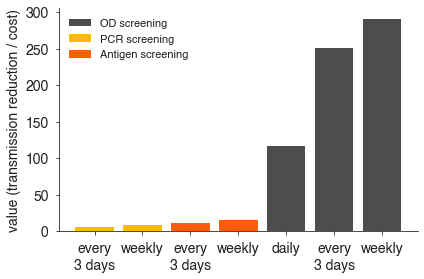

In [63]:
barkeys = [
    (1, 0.36, 5, 7, 1, 0.75, 0),
    (3, 0.36, 5, 7, 1, 0.75, 0),
    (7, 0.36, 5, 7, 1, 0.75, 0),
    (3, 0.19999999999999996, 3, 0, 0, 0, 0),
    (7, 0.19999999999999996, 3, 0, 0, 0, 0),
    (3, 0.19999999999999996, 6, 0, 0, 0, 0),
    (7, 0.19999999999999996, 6, 0, 0, 0, 0)]
costs = []
for key in barkeys:
    D,refusal,L,dur,ons,prev,prev_cutoff = key
    St,It,Rt,Qt,SQt,external,internal,ext_pre,int_pre,ODt,PCRt = sims[key]
    OD_tests = int(np.sum(ODt[:120]))
    PCR_tests = int(np.sum(PCRt[:120]))
    if L==3:
        cost = (20*OD_tests)/1000000
    if L==5:
        cost = (0.25*OD_tests+20*PCR_tests)/1000000
    if L==6:
        cost = (10*OD_tests)/1000000
    costs.append(cost)
costs = np.array(costs)
pct_redux = np.zeros(7)

key = (7,0.75)
particip = 0.64
pct_redux[:3] = (1-particip) + particip*impacts_logproportional[key][0][1,:]

key = 'pcr'
particip = 0.8
pct_redux[3:5] = (1-particip) + particip*impacts_logproportional[key][0][0,1:]

key = 'rapid_ag'
particip = 0.8
pct_redux[5:] = (1-particip) + particip*impacts_logproportional[key][0][0,1:]

value = (1-pct_redux)*100 / costs

fig,ax = fig_setup(1,1)
ax.bar([4,5,6],value[:3],facecolor=grey,label='OD screening')
ax.bar([0,1],value[3:5],facecolor=color_pcr,label='PCR screening')
ax.bar([2,3],value[5:],facecolor=color_ag,label='Antigen screening')
ax.set_xticks([0,1,2,3,4,5,6])
ax.set_xticklabels(['every\n3 days', 'weekly', 'every\n3 days', 'weekly', 'daily', 'every\n3 days', 'weekly'])
ax.set_ylabel('value (transmission reduction / cost)')
ax.legend(fontsize=11, frameon=False)
finalize(ax,ignoreLegend=True)
plt.tight_layout()

plt.savefig('../figs/suppfig_0_value.pdf')
plt.savefig('../figs/suppfig_0_value.png',dpi=150)

In [64]:
keys = list(set(keys))

# Figure 1 - Prevalence

(7, 0.19999999999999996, 6, 0, 0, 0, 0)
(3, 0.36, 5, 7, 2, 0.5, 0)
(3, 0.36, 5, 7, 2, 0.75, 0)
(3, 0.36, 5, 7, 2, 0.25, 0)
(3, 0.36, 5, 7, 2, 0.9, 0)
(7, 0.19999999999999996, 3, 0, 0, 0, 0)
(1, 1, 3, 7, -1, 0.9, 0)


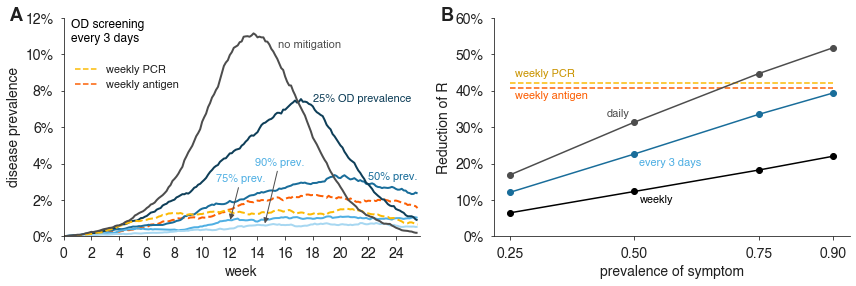

In [65]:
fig,axs = fig_setup(1,2)

ax = axs[0]
plot_idx = 1
for key in keys:
    if plot_idx in plots[key]:
        D,refusal,L,dur,ons,prev,prev_cutoff = key
        col = kolors[key]
        if prev==0.75:
            col = prev_colors[2]
        plot_curve(ax,sims[key],key,col)
        print(key)

particip = 0.64
particip_pcr = 0.8
ax = axs[1]
Q1 = np.zeros(4)
Q3 = np.zeros(4)
Q7 = np.zeros(4)
prevs = [0.25,0.5,0.75,0.9]
for idx,prev in enumerate(prevs):
    key = (7,prev)
    dat = impacts_logproportional[key][0]
    Q1[idx] = 1-((1-particip) + particip*dat[1,0])
    Q3[idx] = 1-((1-particip) + particip*dat[1,1])
    Q7[idx] = 1-((1-particip) + particip*dat[1,2])
ax.plot(prevs,Q1,'-o',color=[0.3,0.3,0.3],zorder=2)
ax.plot(prevs,Q3,'-o',color=prev_colors[1],zorder=2)
ax.plot(prevs,Q7,'-o',color='black',zorder=2)
weekly_pcr = 1-((1-particip_pcr) + particip_pcr*np.mean(impacts_logproportional['pcr'][0][:,2]))
ax.plot([0.25,0.9],[weekly_pcr]*2,color=color_pcr,ls='--',zorder=1)
weekly_ag = 1-((1-particip_pcr) + particip_pcr*np.mean(impacts_logproportional['rapid_ag'][0][:,2]))
ax.plot([0.25,0.9],[weekly_ag]*2,color=color_ag,ls='--',zorder=1)

label(ax,prevs[1],Q1[1],'daily',[0.3,0.3,0.3],'NW')
label(ax,prevs[1],Q3[1],'every 3 days',prev_colors[2],'SE')
label(ax,prevs[1],Q7[1],'weekly','black','SE')
label(ax,prevs[0],weekly_pcr,'weekly PCR',color_pcr_annot,'NE')
label(ax,prevs[0],weekly_ag,'weekly antigen',color_ag,'SE')

ax.set_xlabel('prevalence of symptom')
ax.set_ylabel('Reduction of R')
yts = np.arange(0,0.61,0.1)
axs[1].set_yticklabels([str(int(100*yt))+'%' for yt in yts])
ax.set_xticks(prevs)
ax.set_ylim([0,0.6])

        
ax = axs[0]
ax.text(7*15.5,0.105,'no mitigation',color=grey,fontsize=11,va='center',ha='left')
ax.annotate('25% OD prevalence',(7*18.0,0.074),color=prev_colors[0],fontsize=11)
ax.annotate('50% prev.',(22*7,0.031),color=prev_colors[1],fontsize=11)
ax.annotate('75% prev.',(12*7,0.008),(11*7,0.03),
            arrowprops={'arrowstyle':'-|>','color':grey},fontsize=11,color=prev_colors[2])
ax.annotate('90% prev.',(14.5*7,0.006), (13.8*7,0.039),
           arrowprops={'arrowstyle':'-|>','color':grey},fontsize=11,color=prev_colors[2])

# ax.annotate('weekly PCR',(15.5*7,0.014),fontsize=11,color=color_pcr_annot)
custom_lines = [Line2D([0], [0], color=color_pcr, ls='--'),
                Line2D([0], [0], color=color_ag, ls='--')]
ax.legend(custom_lines, ['weekly PCR', 'weekly antigen'],fontsize=11,loc=(0.02,0.65),frameon=False)

ax.set_xlim([0,180])
ax.text(0.5*7,0.12,'OD screening\nevery 3 days',color='k',fontsize=12,va='top',ha='left')
ax.set_ylim(bottom=0)
ax.set_ylabel('disease prevalence')
ax.set_yticks(np.arange(0,0.121,0.02))
ax.set_yticklabels(['0%','2%','4%','6%','8%','10%','12%'])
ax.set_xticks(np.arange(0,180,14))
ax.set_xticklabels(np.arange(0,180/7,2,dtype=int))
ax.set_xlabel('week')
for ax in axs:
    finalize(ax,ignoreLegend=True)
plt.tight_layout()

labs = ['A', 'B']
for idx, ax in enumerate(axs):
    ax.text(-0.15, 1.05, labs[idx], transform=ax.transAxes, fontname='Arial',
                    fontsize=18, fontweight='bold', va='top', ha='left')
plt.savefig('../figs/fig_1_prevalence.pdf')
plt.savefig('../figs/fig_1_prevalence.png',dpi=150)

# Figure 2 - Onset

(3, 0.36, 5, 7, 1, 0.75, 0)
(7, 0.19999999999999996, 6, 0, 0, 0, 0)
(3, 0.36, 5, 7, 2, 0.75, 0)
(7, 0.19999999999999996, 3, 0, 0, 0, 0)
(3, 0.36, 5, 7, 3, 0.75, 0)
(1, 1, 3, 7, -1, 0.9, 0)
(3, 0.36, 5, 7, 4, 0.75, 0)


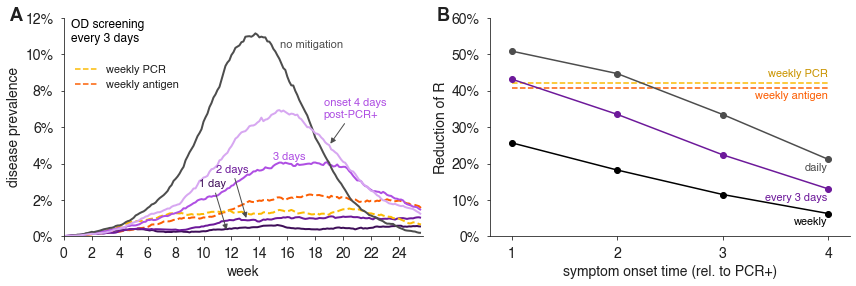

In [66]:
fig,axs = fig_setup(1,2)

ax = axs[0]
plot_idx = 2
for key in list(set(keys)):
    if plot_idx in plots[key]:
        D,refusal,L,dur,ons,prev,prev_cutoff = key
        col = kolors[key]
        if ons==2 and (L==5):
            col = ons_colors[2]
        plot_curve(ax,sims[key],key,col)
        print(key)

ax = axs[1]
particip = 0.64
particip_pcr = 0.8
key = (7,0.75)
dat = impacts_logproportional[key][0]
Q1 = 1-((1-particip) + particip*dat[:,0])
Q3 = 1-((1-particip) + particip*dat[:,1])
Q7 = 1-((1-particip) + particip*dat[:,2])
ax.plot(onsvals,Q1,'-o',color=[0.3,0.3,0.3],zorder=2)
ax.plot(onsvals,Q3,'-o',color=ons_colors[2],zorder=2)
ax.plot(onsvals,Q7,'-o',color='black',zorder=2)
weekly_pcr = 1-((1-particip_pcr) + particip_pcr*np.mean(impacts_logproportional['pcr'][0][:,2]))
ax.plot([1,4],[weekly_pcr]*2,color=color_pcr,ls='--',zorder=1)
weekly_ag = 1-((1-particip_pcr) + particip_pcr*np.mean(impacts_logproportional['rapid_ag'][0][:,2]))
ax.plot([1,4],[weekly_ag]*2,color=color_ag,ls='--',zorder=1)

label(ax,onsvals[3],Q1[3],'daily',[0.3,0.3,0.3],'SW')
label(ax,onsvals[3],Q3[3],'every 3 days',ons_colors[2],'SW')
label(ax,onsvals[3],Q7[3],'weekly','black','SW')
label(ax,onsvals[3],weekly_pcr,'weekly PCR',color_pcr_annot,'NW')
label(ax,onsvals[3],weekly_ag,'weekly antigen',color_ag,'SW')

ax.set_xlabel('symptom onset time (rel. to PCR+)')
ax.set_ylabel('Reduction of R')
yts = np.arange(0,0.61,0.1)
axs[1].set_yticklabels([str(int(100*yt))+'%' for yt in yts])
ax.set_xticks(onsvals)
ax.set_xlim([0.8,4.2])
ax.set_ylim([0,0.6])

ax = axs[0]
ax.text(7*15.5,0.105,'no mitigation',color=grey,fontsize=11,va='center',ha='left')

ax.annotate('1 day', (11.7*7,0.0025),(9.7*7,0.027),
           arrowprops={'arrowstyle':'-|>','color':grey},fontsize=11,color=ons_colors[1])

ax.annotate('2 days', (13.1*7,0.009),(10.9*7,0.035),
           arrowprops={'arrowstyle':'-|>','color':grey},fontsize=11,color=ons_colors[2])

ax.annotate('3 days',(15*7,0.042),color=ons_colors[3],fontsize=11)
ax.annotate('onset 4 days\npost-PCR+',(19*7,0.05),(18.6*7,0.065),
            arrowprops={'arrowstyle':'-|>','color':grey},color=ons_colors[3],fontsize=11)
# ax.annotate('weekly PCR',(15.5*7,0.012),fontsize=11,color=color_pcr_annot)

custom_lines = [Line2D([0], [0], color=color_pcr, ls='--'),
                Line2D([0], [0], color=color_ag, ls='--')]
ax.legend(custom_lines, ['weekly PCR', 'weekly antigen'],fontsize=11,loc=(0.02,0.65),frameon=False)
        
ax = axs[0]
ax.set_xlim([0,180])
ax.text(0.5*7,0.12,'OD screening\nevery 3 days',color='k',fontsize=12,va='top',ha='left')
ax.set_ylim(bottom=0)
ax.set_ylabel('disease prevalence')
ax.set_yticks(np.arange(0,0.121,0.02))
ax.set_yticklabels(['0%','2%','4%','6%','8%','10%','12%'])
ax.set_xticks(np.arange(0,180,14))
ax.set_xticklabels(np.arange(0,180/7,2,dtype=int))
ax.set_xlabel('week')
for ax in axs:
    finalize(ax,ignoreLegend=True)
plt.tight_layout()
labs = ['A', 'B']
for idx, ax in enumerate(axs):
    ax.text(-0.15, 1.05, labs[idx], transform=ax.transAxes, fontname='Arial',
                    fontsize=18, fontweight='bold', va='top', ha='left')
plt.savefig('../figs/fig_2_onset.pdf')
plt.savefig('../figs/fig_2_onset.png',dpi=150)

# Figure 3 - Duration

(3, 0.36, 5, 3, 2, 0.75, 0)
(3, 0.36, 5, 1, 2, 0.75, 0)
(7, 0.19999999999999996, 6, 0, 0, 0, 0)
(3, 0.36, 5, 7, 2, 0.75, 0)
(3, 0.36, 5, 5, 2, 0.75, 0)
(7, 0.19999999999999996, 3, 0, 0, 0, 0)
(1, 1, 3, 7, -1, 0.9, 0)


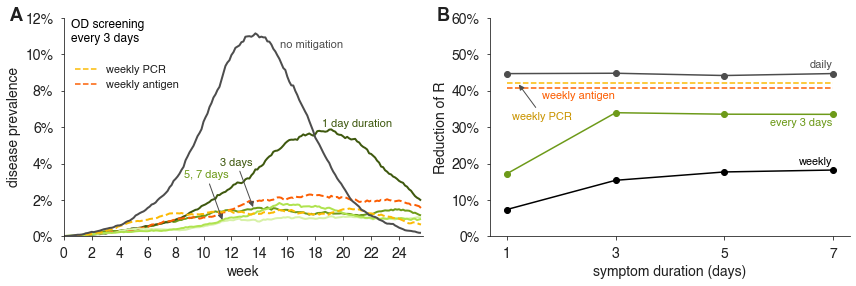

In [67]:
fig,axs = fig_setup(1,2)

ax = axs[0]
plot_idx = 3
for key in keys:
    if plot_idx in plots[key]:
        D,refusal,L,dur,ons,prev,prev_cutoff = key
        plot_curve(ax,sims[key],key,kolors[key])
        print(key)

ax = axs[1]
particip = 0.64
particip_pcr = 0.8
Q1 = np.zeros(4)
Q3 = np.zeros(4)
Q7 = np.zeros(4)
for idx,dur in enumerate(durvals):
    key = (dur,0.75)
    dat = impacts_logproportional[key][0]
    Q1[idx] = 1-((1-particip) + particip*dat[1,0])
    Q3[idx] = 1-((1-particip) + particip*dat[1,1])
    Q7[idx] = 1-((1-particip) + particip*dat[1,2])
ax.plot(durvals,Q1,'-o',color=[0.3,0.3,0.3])
ax.plot(durvals,Q3,'-o',color=dur_colors[1])
ax.plot(durvals,Q7,'-o',color='black')
weekly_pcr = 1-((1-particip_pcr) + particip_pcr*np.mean(impacts_logproportional['pcr'][0][:,2]))
ax.plot([1,7],[weekly_pcr]*2,color=color_pcr,ls='--',zorder=1)
weekly_ag = 1-((1-particip_pcr) + particip_pcr*np.mean(impacts_logproportional['rapid_ag'][0][:,2]))
ax.plot([1,7],[weekly_ag]*2,color=color_ag,ls='--',zorder=1)

label(ax,durvals[3],Q7[3],'weekly','black','NW')
label(ax,durvals[3],Q3[3],'every 3 days',dur_colors[1],'SW')
label(ax,durvals[3],Q1[3],'daily',[0.3,0.3,0.3],'NW')
# label(ax,durvals[0],weekly_pcr,'weekly PCR',color_pcr_annot,'NE')
label(ax,durvals[1],weekly_ag,'weekly antigen',color_ag,'SW')
ax.annotate('weekly PCR', (durvals[0]+0.2,weekly_pcr), (durvals[0]+0.1,weekly_pcr-0.1),
           arrowprops={'arrowstyle':'-|>','color':grey},fontsize=11,color=color_pcr_annot)
        
ax.set_xlabel('symptom duration (days)')
ax.set_ylabel('Reduction of R')
yts = np.arange(0,0.61,0.1)
axs[1].set_yticklabels([str(int(100*yt))+'%' for yt in yts])
ax.set_xticks(durvals)
ax.set_ylim([0,0.6])
    
ax = axs[0]
ax.text(7*15.5,0.105,'no mitigation',color=grey,fontsize=11,va='center',ha='left')
ax.annotate('1 day duration',(18.5*7,0.060),color=dur_colors[0],fontsize=11)
ax.annotate('5, 7 days', (11.4*7,0.008), (8.6*7,0.032),
           arrowprops={'arrowstyle':'-|>','color':grey},fontsize=11,color=dur_colors[1])
ax.annotate('3 days', (13.6*7,0.015), (11.2*7,0.039),
           arrowprops={'arrowstyle':'-|>','color':grey},fontsize=11,color=dur_colors[0])
# ax.annotate('weekly PCR',(15.5*7,0.012),fontsize=11,color=color_pcr_annot)

custom_lines = [Line2D([0], [0], color=color_pcr, ls='--'),
                Line2D([0], [0], color=color_ag, ls='--')]
ax.legend(custom_lines, ['weekly PCR', 'weekly antigen'],fontsize=11,loc=(0.02,0.65),frameon=False)

ax = axs[0]
ax.set_xlim([0,180])
ax.text(0.5*7,0.12,'OD screening\nevery 3 days',color='k',fontsize=12,va='top',ha='left')
ax.set_ylim(bottom=0)
ax.set_ylabel('disease prevalence')
ax.set_yticks(np.arange(0,0.121,0.02))
ax.set_yticklabels(['0%','2%','4%','6%','8%','10%','12%'])
ax.set_xticks(np.arange(0,180,14))
ax.set_xticklabels(np.arange(0,180/7,2,dtype=int))
ax.set_xlabel('week')
for ax in axs:
    finalize(ax,ignoreLegend=True)
plt.tight_layout()
yts = axs[1].get_yticks()
axs[1].set_yticklabels([str(int(100*yt))+'%' for yt in yts])
labs = ['A', 'B']
for idx, ax in enumerate(axs):
    ax.text(-0.15, 1.05, labs[idx], transform=ax.transAxes, fontname='Arial',
                    fontsize=18, fontweight='bold', va='top', ha='left')
plt.savefig('../figs/fig_3_duration.pdf')
plt.savefig('../figs/fig_3_duration.png',dpi=150)

# Figure 4 - Outbreak

(7, 0.36, 5, 7, 2, 0.75, 0.02)
(7, 0.19999999999999996, 6, 0, 0, 0, 0.02)
(3, 0.36, 5, 7, 2, 0.75, 0.02)
(1, 1, 3, 7, -1, 0.9, 0.02)
(1, 0.36, 5, 7, 2, 0.75, 0.02)
(7, 0.19999999999999996, 3, 0, 0, 0, 0.02)


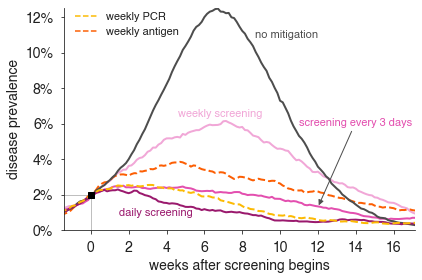

In [68]:
fig,ax = fig_setup(1,1)

plot_idx = 4
for key in keys:
    if plot_idx in plots[key]:
        D,refusal,L,dur,ons,prev,prev_cutoff = key
        plot_curve(ax,sims[key],key,kolors[key])
        print(key)

ax.set_xlim([-10,120])
ax.set_ylim([0,0.125])
finalize(ax,ignoreLegend=True)
ax.set_ylabel('disease prevalence')
ax.set_yticks(np.arange(0,0.121,0.02))
ax.set_yticklabels(['0%','2%','4%','6%','8%','10%','12%'])
ax.set_xticks(np.arange(0,120,14))
ax.set_xticklabels(np.arange(0,180/7,2,dtype=int))
ax.set_xlabel('weeks after screening begins')

ax.text(8.7*7,0.11,'no mitigation',color=grey,fontsize=11,va='center',ha='left')

ax.annotate('daily screening',(1.5*7,0.008),fontsize=11,color=Q_colors[0])
ax.annotate('weekly screening',(4.6*7,0.064),fontsize=11,color=Q_colors[2])

ax.annotate('screening every 3 days',(12*7,0.013),(11*7,0.059),
            arrowprops={'arrowstyle':'-|>','color':grey},fontsize=11,color=Q_colors[1])
# ax.annotate('weekly PCR',(3.2*7,0.026),(-0.9*7,0.055),
#             arrowprops={'arrowstyle':'-|>','color':grey},fontsize=11,color=color_pcr_annot)

custom_lines = [Line2D([0], [0], color=color_pcr, ls='--'),
                Line2D([0], [0], color=color_ag, ls='--')]
ax.legend(custom_lines, ['weekly PCR', 'weekly antigen'],fontsize=11,loc=(0.02,0.85),frameon=False)

ax.plot([0,0],[0,prev_cutoff],lw=0.5,color='k',alpha=0.5,zorder=1)
ax.plot([-10,0],[prev_cutoff,prev_cutoff],lw=0.5,color='k',alpha=0.5,zorder=1)
ax.scatter(0,prev_cutoff,marker='s',facecolor='k',edgecolor='k',zorder=3)
ax.set_xlim([-10,120])
finalize(ax,ignoreLegend=True)

plt.tight_layout()
plt.savefig('../figs/fig_5_outbreak.pdf')
plt.savefig('../figs/fig_5_outbreak.png',dpi=150)

# Impact Figure

0.2
3.1
0.0
(7, 0.36, 5, 7, 2, 0.75, 0.02)
(7, 0.19999999999999996, 6, 0, 0, 0, 0.02)
(3, 0.36, 5, 7, 2, 0.75, 0.02)
(1, 1, 3, 7, -1, 0.9, 0.02)
(1, 0.36, 5, 7, 2, 0.75, 0.02)
(7, 0.19999999999999996, 3, 0, 0, 0, 0.02)


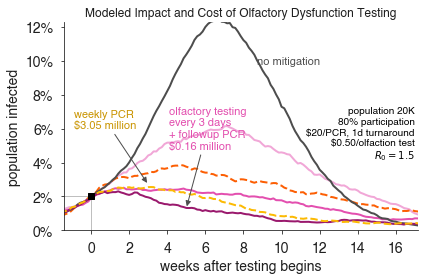

In [69]:
costkeys = [
    (3, 0.36, 5, 7, 2, 0.75, 0.02),
    (7, 0.19999999999999996, 3, 0, 0, 0, 0.02),
    (1, 1, 3, 7, -1, 0.9, 0.02),]
costs = {}

for idx,key in enumerate(costkeys):
    D,refusal,L,dur,ons,prev,prev_cutoff = key
    St,It,Rt,Qt,SQt,external,internal,ext_pre,int_pre,ODt,PCRt = sims[key]
    OD_tests = int(np.sum(ODt[:120]))
    PCR_tests = int(np.sum(PCRt[:120]))
    if L==3:
        cost = (20*OD_tests)/1000000
    if L==5:
        cost = (OD_tests/2+20*PCR_tests)/1000000
    costs[key] = np.round(cost,2)
    print(np.round(cost,1))


fig,ax = fig_setup(1,1)

plot_idx = 4
for key in keys:
    if plot_idx in plots[key]:
        D,refusal,L,dur,ons,prev,prev_cutoff = key
        if key in [(1, 0.19999999999999996, 5, 7, 2, 0.75, 0.02),
                   (7, 0.19999999999999996, 5, 7, 2, 0.75, 0.02)]:
            continue
        plot_curve(ax,sims[key],key,kolors[key])
        print(key)

ax.set_xlim([-10,120])
ax.set_ylim([0,0.123])
finalize(ax,ignoreLegend=True)
ax.set_ylabel('population infected')
ax.set_yticks(np.arange(0,0.121,0.02))
ax.set_yticklabels(['0%','2%','4%','6%','8%','10%','12%'])
ax.set_xticks(np.arange(0,120,14))
ax.set_xticklabels(np.arange(0,180/7,2,dtype=int))
ax.set_xlabel('weeks after testing begins')

ax.text(8.7*7,0.1,'no mitigation',color=grey,fontsize=11,va='center',ha='left')
ax.annotate('olfactory testing\nevery 3 days\n+ followup PCR\n${:.2f} million'.format(
    costs[costkeys[0]]),(5.0*7,0.013),(4.1*7,0.048),
            arrowprops={'arrowstyle':'-|>','color':grey},fontsize=11,color=Q_colors[1])
ax.annotate('weekly PCR\n${} million'.format(
    costs[costkeys[1]]),(3*7,0.027),(-0.9*7,0.06),
            arrowprops={'arrowstyle':'-|>','color':grey},fontsize=11,color=color_pcr_annot)

ax.plot([0,0],[0,prev_cutoff],lw=0.5,color='k',alpha=0.5,zorder=1)
ax.plot([-10,0],[prev_cutoff,prev_cutoff],lw=0.5,color='k',alpha=0.5,zorder=1)
ax.scatter(0,prev_cutoff,marker='s',facecolor='k',edgecolor='k',zorder=3)
ax.set_xlim([-10,120])
finalize(ax,ignoreLegend=True)

ax.text(17*7,0.04,
        'population 20K\n80% participation\n\$20/PCR, 1d turnaround\n\$0.50/olfaction test\n$R_0=1.5$',
        color='k',fontsize=10,va='bottom',ha='right')

ax.set_title('Modeled Impact and Cost of Olfactory Dysfunction Testing')
plt.tight_layout()
plt.savefig('../figs/impact.pdf')
plt.savefig('../figs/impact.png',dpi=300)

# Figure 5 - Sensitivity Analysis

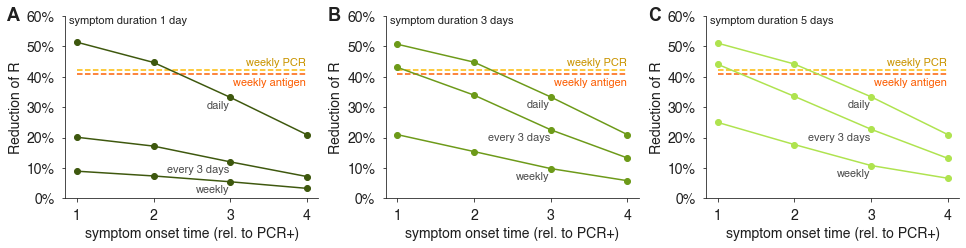

In [70]:
fig,axs = fig_setup(1,3,4.5,3.5,)
particip = 0.64
particip_pcr = 0.8

weekly_pcr = particip_pcr - particip_pcr*np.mean(impacts_logproportional['pcr'][0][:,2])
weekly_ag = particip_pcr - particip_pcr*np.mean(impacts_logproportional['rapid_ag'][0][:,2])
for idx,d in enumerate(durvals[:-1]):
    p=0.75
    key = (d,p)
    dat = particip - particip*impacts_logproportional[key][0]
    axs[idx].plot(onsvals,dat,'-o',color=dur_colors[idx])
    for idQ,Q in enumerate(['daily','every 3 days','weekly']):
        label(axs[idx], onsvals[2], dat[2,idQ], Q, grey, 'SW')
    axs[idx].plot([1,4],[weekly_pcr]*2,color=color_pcr,ls='--',zorder=1)
    axs[idx].plot([1,4],[weekly_ag]*2,color=color_ag,ls='--',zorder=1)
    label(axs[idx],onsvals[3],weekly_pcr,'weekly PCR',color_pcr_annot,'NW')
    label(axs[idx],onsvals[3],weekly_ag,'weekly antigen',color_ag,'SW')


labs = ['symptom duration 1 day',
        'symptom duration 3 days',
        'symptom duration 5 days']

for idx,ax in enumerate(axs):
    ax.set_ylabel('Reduction of R')
    yts = np.arange(0,0.61,0.1)
    ax.set_yticklabels([str(int(100*yt))+'%' for yt in yts])
    ax.set_xlabel('symptom onset time (rel. to PCR+)')
    ax.text(1-0.1,0.6,labs[idx],va='top',ha='left',fontsize=11)
    finalize(ax,ignoreLegend=True)
    ax.set_ylim([0,0.6])
    ax.set_xticks(onsvals)

plt.tight_layout()
labs = ['A', 'B','C']
for idx, ax in enumerate(axs):
    ax.text(-0.23, 1.05, labs[idx], transform=ax.transAxes, fontname='Arial',
                    fontsize=18, fontweight='bold', va='top', ha='left')
plt.savefig('../figs/fig_4_sensitivity.pdf')
plt.savefig('../figs/fig_4_sensitivity.png',dpi=150)

# SUPP Figure 1 - Prevalence

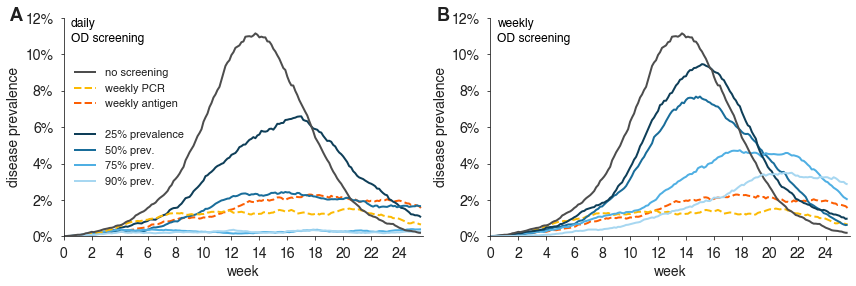

In [73]:
fig,axs = fig_setup(1,2)

ax = axs[0]
plot_idx = 111
for key in keys:
    if plot_idx in plots[key]:
        D,refusal,L,dur,ons,prev,prev_cutoff = key
        col = kolors[key]
        if prev==0.75:
            col = prev_colors[2]
        plot_curve(ax,sims[key],key,col)

ax = axs[1]
plot_idx = 117
for key in keys:
    if plot_idx in plots[key]:
        D,refusal,L,dur,ons,prev,prev_cutoff = key
        col = kolors[key]
        if prev==0.75:
            col = prev_colors[2]
        plot_curve(ax,sims[key],key,col)
        
leg = [Line2D([0], [0], color=grey, lw=2, label='no screening'),
       Line2D([0], [0], color=color_pcr, lw=2, ls='--', label='weekly PCR'),
       Line2D([0], [0], color=color_ag, lw=2, ls='--', label='weekly antigen'),
       Line2D([0], [0], color='None', lw=2, ls='--', label=''),
       Line2D([0], [0], color=prev_colors[0], lw=2, label='25% prevalence'),
       Line2D([0], [0], color=prev_colors[1], lw=2, label='50% prev.'),
       Line2D([0], [0], color=prev_colors[2], lw=2, label='75% prev.'),
       Line2D([0], [0], color=prev_colors[3], lw=2, label='90% prev.'),]
axs[0].legend(handles=leg,loc='center left',fontsize=11,frameon=False)
        
axs[0].text(0.5*7,0.12,'daily\nOD screening',color='k',fontsize=12,va='top',ha='left')
axs[1].text(0.5*7,0.12,'weekly\nOD screening',color='k',fontsize=12,va='top',ha='left')
for ax in axs:
    ax.set_xlim([0,180])
    ax.set_ylim(bottom=0)
    ax.set_ylabel('disease prevalence')
    ax.set_yticks(np.arange(0,0.121,0.02))
    ax.set_yticklabels(['0%','2%','4%','6%','8%','10%','12%'])
    ax.set_xticks(np.arange(0,180,14))
    ax.set_xticklabels(np.arange(0,180/7,2,dtype=int))
    ax.set_xlabel('week')
    finalize(ax,ignoreLegend=True)
plt.tight_layout()
labs = ['A', 'B']
for idx, ax in enumerate(axs):
    ax.text(-0.15, 1.05, labs[idx], transform=ax.transAxes, fontname='Arial',
                    fontsize=18, fontweight='bold', va='top', ha='left')
plt.savefig('../figs/suppfig_1_prevalence.pdf')
plt.savefig('../figs/suppfig_1_prevalence.png',dpi=150)

# SUPP Figure 2 - Onset

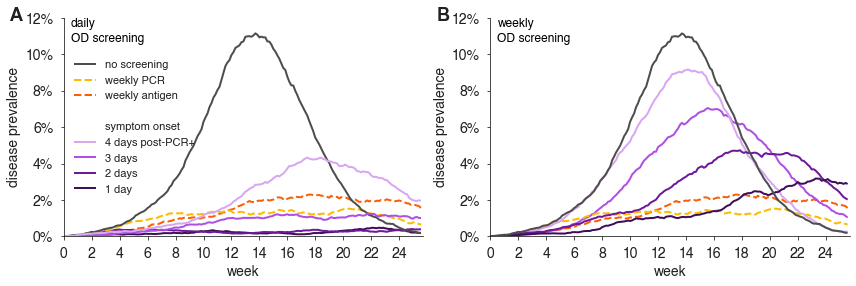

In [75]:
fig,axs = fig_setup(1,2)

ax = axs[0]
plot_idx = 121
for key in keys:
    if plot_idx in plots[key]:
        D,refusal,L,dur,ons,prev,prev_cutoff = key
        col = kolors[key]
        if ons==2 and (L==5):
            col = ons_colors[2]
        plot_curve(ax,sims[key],key,col)
ax = axs[1]
plot_idx = 127
for key in keys:
    if plot_idx in plots[key]:
        D,refusal,L,dur,ons,prev,prev_cutoff = key
        col = kolors[key]
        if ons==2 and (L==5):
            col = ons_colors[ons]
        plot_curve(ax,sims[key],key,col)

leg = [Line2D([0], [0], color=grey, lw=2, label='no screening'),
       Line2D([0], [0], color=color_pcr, lw=2, ls='--', label='weekly PCR'),
      Line2D([0], [0], color=color_ag, lw=2, ls='--', label='weekly antigen'),
       Line2D([0], [0], color='None', lw=2, ls='--', label=''),
       Line2D([0], [0], color='None', lw=2, ls='--', label='symptom onset'),
       Line2D([0], [0], color=ons_colors[4], lw=2, label='4 days post-PCR+'),
       Line2D([0], [0], color=ons_colors[3], lw=2, label='3 days'),
       Line2D([0], [0], color=ons_colors[2], lw=2, label='2 days'),
       Line2D([0], [0], color=ons_colors[1], lw=2, label='1 day'),]
axs[0].legend(handles=leg,loc='center left',fontsize=11,frameon=False)
        
axs[0].text(0.5*7,0.12,'daily\nOD screening',color='k',fontsize=12,va='top',ha='left')
axs[1].text(0.5*7,0.12,'weekly\nOD screening',color='k',fontsize=12,va='top',ha='left')
for ax in axs:
    ax.set_xlim([0,180])
    ax.set_ylim(bottom=0)
    ax.set_ylabel('disease prevalence')
    ax.set_yticks(np.arange(0,0.121,0.02))
    ax.set_yticklabels(['0%','2%','4%','6%','8%','10%','12%'])
    ax.set_xticks(np.arange(0,180,14))
    ax.set_xticklabels(np.arange(0,180/7,2,dtype=int))
    ax.set_xlabel('week')
    finalize(ax,ignoreLegend=True)
plt.tight_layout()
labs = ['A', 'B']
for idx, ax in enumerate(axs):
    ax.text(-0.15, 1.05, labs[idx], transform=ax.transAxes, fontname='Arial',
                    fontsize=18, fontweight='bold', va='top', ha='left')
plt.savefig('../figs/suppfig_2_onset.pdf')
plt.savefig('../figs/suppfig_2_onset.png',dpi=150)

# SUPP Figure 3 - Duration

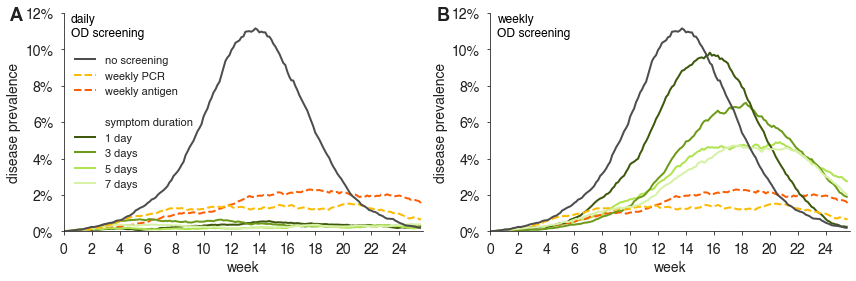

In [76]:
fig,axs = fig_setup(1,2)

ax = axs[0]
plot_idx = 131
for key in keys:
    if plot_idx in plots[key]:
        D,refusal,L,dur,ons,prev,prev_cutoff = key
        plot_curve(ax,sims[key],key,kolors[key])
ax = axs[1]
plot_idx = 137
for key in keys:
    if plot_idx in plots[key]:
        D,refusal,L,dur,ons,prev,prev_cutoff = key
        plot_curve(ax,sims[key],key,kolors[key])

leg = [Line2D([0], [0], color=grey, lw=2, label='no screening'),
       Line2D([0], [0], color=color_pcr, lw=2, ls='--', label='weekly PCR'),
      Line2D([0], [0], color=color_ag, lw=2, ls='--', label='weekly antigen'),
       Line2D([0], [0], color='None', lw=2, ls='--', label=''),
       Line2D([0], [0], color='None', lw=2, ls='--', label='symptom duration'),
       Line2D([0], [0], color=dur_colors[0], lw=2, label='1 day'),
       Line2D([0], [0], color=dur_colors[1], lw=2, label='3 days'),
       Line2D([0], [0], color=dur_colors[2], lw=2, label='5 days'),
       Line2D([0], [0], color=dur_colors[3], lw=2, label='7 days'),]
axs[0].legend(handles=leg,loc='center left',fontsize=11,frameon=False)
        
axs[0].text(0.5*7,0.12,'daily\nOD screening',color='k',fontsize=12,va='top',ha='left')
axs[1].text(0.5*7,0.12,'weekly\nOD screening',color='k',fontsize=12,va='top',ha='left')
for ax in axs:
    ax.set_xlim([0,180])
    ax.set_ylim(bottom=0)
    ax.set_ylabel('disease prevalence')
    ax.set_yticks(np.arange(0,0.121,0.02))
    ax.set_yticklabels(['0%','2%','4%','6%','8%','10%','12%','14%'])
    ax.set_xticks(np.arange(0,180,14))
    ax.set_xticklabels(np.arange(0,180/7,2,dtype=int))
    ax.set_xlabel('week')
    finalize(ax,ignoreLegend=True)
plt.tight_layout()
labs = ['A', 'B']
for idx, ax in enumerate(axs):
    ax.text(-0.15, 1.03, labs[idx], transform=ax.transAxes, fontname='Arial',
                    fontsize=18, fontweight='bold', va='top', ha='left')
plt.savefig('../figs/suppfig_3_duration.pdf')
plt.savefig('../figs/suppfig_3_duration.png',dpi=150)

# Supp Figs Sims

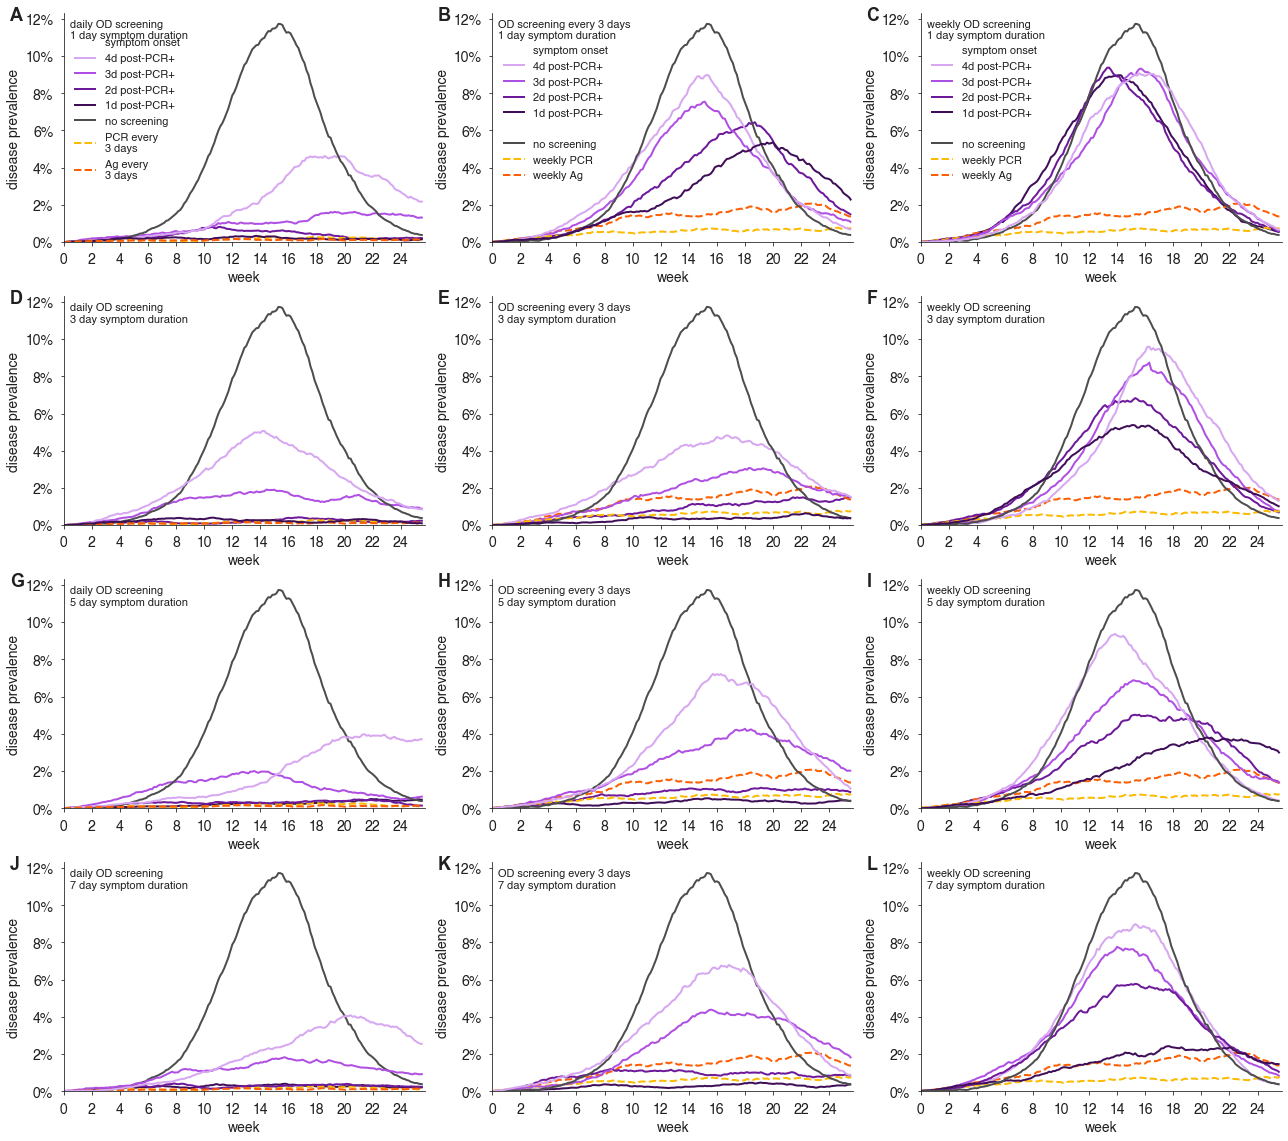

In [46]:
fig,axs = plt.subplots(nrows=4,ncols=3,figsize=(3*6,4*4))
for key in keys_supp:
    D,refusal,L,dur,ons,prev,prev_cutoff = key
    dat = sims_supp[key]
    for p in plots_supp[key]:
        ax = axs[p[0],p[1]]
        plot_curve(ax,dat,key,kolors_supp[key])
cols = ['daily OD screening','OD screening every 3 days','weekly OD screening']
rows = ['1 day symptom duration','3 day symptom duration','5 day symptom duration','7 day symptom duration']
for i in range(3):
    for j in range(4):
        lab = cols[i]+'\n'+rows[j]
        axs[j,i].text(3, 0.12, lab,ha='left',va='top',fontsize=11,)

for ax in axs.flatten():
    ax.set_xlim([0,180])
    ax.set_ylim(bottom=0)
    ax.set_ylabel('disease prevalence')
    ax.set_ylim([0,0.123])
    ax.set_yticks(np.arange(0,0.121,0.02))
    ax.set_yticklabels(['0%','2%','4%','6%','8%','10%','12%',])
    ax.set_xticks(np.arange(0,180,14))
    ax.set_xticklabels(np.arange(0,180/7,2,dtype=int))
    ax.set_xlabel('week')
    finalize(ax,ignoreLegend=True)
    
leg = [Line2D([0], [0], color='None', lw=2, ls='--', label='symptom onset'),
       Line2D([0], [0], color=ons_colors[4], lw=2, label='4d post-PCR+'),
       Line2D([0], [0], color=ons_colors[3], lw=2, label='3d post-PCR+'),
       Line2D([0], [0], color=ons_colors[2], lw=2, label='2d post-PCR+'),
      Line2D([0], [0], color=ons_colors[1], lw=2, label='1d post-PCR+'),
       Line2D([0], [0], color='None', lw=2, ls='--', label=''),
       Line2D([0], [0], color=grey, lw=2, label='no screening'),
       Line2D([0], [0], color=color_pcr, lw=2, ls='--', label='weekly PCR'),
       Line2D([0], [0], color=color_ag, lw=2, ls='--', label='weekly Ag')]
axs[0,1].legend(handles=leg,loc=(3/180,0.25),fontsize=11,frameon=False)
axs[0,2].legend(handles=leg,loc=(3/180,0.25),fontsize=11,frameon=False)

leg = [Line2D([0], [0], color='None', lw=2, ls='--', label='symptom onset'),
       Line2D([0], [0], color=ons_colors[4], lw=2, label='4d post-PCR+'),
       Line2D([0], [0], color=ons_colors[3], lw=2, label='3d post-PCR+'),
       Line2D([0], [0], color=ons_colors[2], lw=2, label='2d post-PCR+'),
       Line2D([0], [0], color=ons_colors[1], lw=2, label='1d post-PCR+'),
       Line2D([0], [0], color=grey, lw=2, label='no screening'),
       Line2D([0], [0], color=color_pcr, lw=2, ls='--', label='PCR every\n3 days'),
      Line2D([0], [0], color=color_ag, lw=2, ls='--', label='Ag every\n3 days')]
axs[0,0].legend(handles=leg,loc=(3/180,0.25),fontsize=11,frameon=False)
plt.tight_layout()
labs = [['A','B','C'],['D','E','F'],['G','H','I'],['J','K','L']]

for i in range(3):
    for j in range(4):
        ax = axs[j,i]
        ax.text(-0.15, 1.03, labs[j][i], transform=ax.transAxes, fontname='Arial',
                    fontsize=18, fontweight='bold', va='top', ha='left')

plt.savefig('../figs/suppfig_4_sensitivity.pdf')
plt.savefig('../figs/suppfig_4_sensitivity.png',dpi=150)

# Supp Figs Oneshot Twoshot

In [42]:
is_recompute = False

np.random.seed(5)

onsvals = [1,2,3,4]
durvals = [2,2,7,7,7,7]
probs = [0.1,0.3,0.25,0.5,0.75,0.9]
asymp = 0.65
n_samples=10000
keys = list(zip(durvals,probs))
impacts_logproportional_oneshot = {}

if is_recompute==True:
    for key in keys:
        if key=='pcr':
            impacts_logproportional_oneshot[key] = 1
        else:
            dur = key[0]
            prob = key[1]
            impacts_logproportional_oneshot[key] = impact_oneshot(logproportional,dur,onsvals,prob,asymptomatic=asymp,n_samples=n_samples)
        # fraction_caught

    with open('impacts_logproportional_oneshot.pkl','wb') as f:
        pickle.dump(impacts_logproportional_oneshot,f)
else:    
    with open('impacts_logproportional_oneshot.pkl','rb') as f:
        impacts_logproportional_oneshot = pickle.load(f)

(2, 0.1)
(2, 0.3)
(7, 0.25)
(7, 0.5)
(7, 0.75)
(7, 0.9)


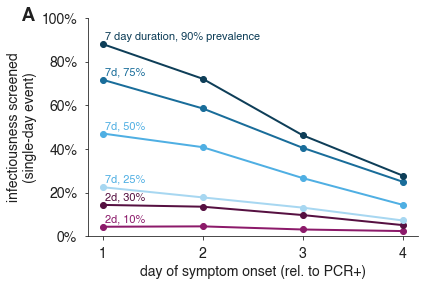

In [36]:
fig,ax = fig_setup(1,1)
prev_colors = list(np.flipud(['#0e3e58','#196d9a','#4fafe3','#a7d7f1']))
colors = np.array(['#8C1A6A','#561041',]+prev_colors)
x = [1,2,3,4]
yoffset = 0.03
xoffset = 0.15
# textpoint = [1,1,1,1,1,1]
textpoint = [0,0,0,0,0,0]

for ii,key in enumerate(keys):
    print(key)
    dur = key[0]
    prob = key[1]
    y = impacts_logproportional_oneshot[(dur,prob)]
    if ii==5:
        lab = '{} day duration, {:.0f}% prevalence'.format(dur,prob*100)
    else:
        lab = '{}d, {:.0f}%'.format(dur,prob*100)
    ax.plot(x,y,'-o',color=colors[ii],lw=2)
    if ii==2:
        label(ax,x[textpoint[ii]],
            y[textpoint[ii]],
            lab,
            color=colors[ii+1],loc='NE',xoffset=0.02,yoffset=0.012)
    else:
        label(ax,x[textpoint[ii]],
            y[textpoint[ii]],
            lab,
            color=colors[ii],loc='NE',xoffset=0.02,yoffset=0.012)
ax.set_ylim([0,1])
ax.set_ylabel('infectiousness screened\n(single-day event)')
ax.set_xlabel('day of symptom onset (rel. to PCR+)')
ax.set_xticks(np.arange(1,4.1))

yt = ax.get_yticks()
ytl = ['{:.0f}%'.format(y*100) for y in yt]
ax.set_yticklabels(ytl)

# ax.legend(title='prevalence\nand duration',loc='upper right')
finalize(ax,ignoreLegend=True)

fig.tight_layout()

labs = ['A']
ax.text(-0.2, 1.05, labs[0], transform=ax.transAxes, fontname='Arial',
                    fontsize=18, fontweight='bold', va='top', ha='left')
plt.savefig('../figs/suppfig_8_oneshot.pdf')
plt.savefig('../figs/suppfig_8_oneshot.png',dpi=150)

### Twoshot

In [37]:
is_recompute=False

np.random.seed(4)

onsvals = [1,2,3,4]
durvals = [2,2,7,7,7,7]
probs = [0.1,0.3,0.25,0.5,0.75,0.9]
asymp = 0.65
n_samples=10000
keys = list(zip(durvals,probs))
fpr_rapid = 0.025
L = 6
impacts_logproportional_twoshot = {}
if is_recompute==True:
    for key in keys:
        dur = key[0]
        prob = key[1]
        if dur==2:
            fpr_smell = 0.01
        else:
            fpr_smell = 0.20
        impacts_logproportional_twoshot[key] = impact_twoshot(logproportional,dur,onsvals,prob,
                                                              asymptomatic=asymp,
                                                              fpr_smell = fpr_smell,
                                                              fpr_rapid = fpr_rapid,
                                                              L=L,
                                                              n_samples=n_samples)
    with open('impacts_logproportional_twoshot.pkl','wb') as f:
        pickle.dump(impacts_logproportional_twoshot,f)
else:
    with open('impacts_logproportional_twoshot.pkl','rb') as f:
        impacts_logproportional_twoshot = pickle.load(f)
    #impacts,olfactories,rapids

(2, 0.1)
(2, 0.3)
(7, 0.25)
(7, 0.5)
(7, 0.75)
(7, 0.9)


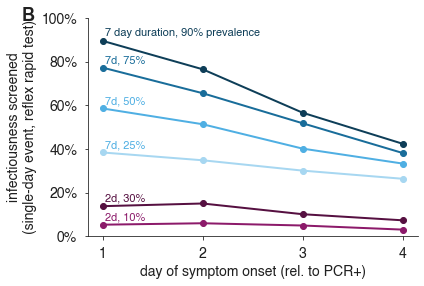

In [38]:
fig,ax = fig_setup(1,1)
prev_colors = list(np.flipud(['#0e3e58','#196d9a','#4fafe3','#a7d7f1']))
colors = np.array(['#8C1A6A','#561041',]+prev_colors)
x = [1,2,3,4]
yoffset = 0.03
xoffset = 0.15
textpoint = [0,0,0,0,0,0]

for ii,key in enumerate(keys):
    print(key)
    dur = key[0]
    prob = key[1]
    y = impacts_logproportional_twoshot[(dur,prob)][0]
    if ii==5:
        lab = '{} day duration, {:.0f}% prevalence'.format(dur,prob*100)
    else:
        lab = '{}d, {:.0f}%'.format(dur,prob*100)
    ax.plot(x,y,'-o',color=colors[ii],lw=2)
    # label(ax,x,y,string,color,loc)
    if ii==2:
        label(ax,x[textpoint[ii]],
            y[textpoint[ii]],
            lab,
            color=colors[ii+1],loc='NE',xoffset=0.02,yoffset=0.012)
    else:
        label(ax,x[textpoint[ii]],
            y[textpoint[ii]],
            lab,
            color=colors[ii],loc='NE',xoffset=0.02,yoffset=0.012)
ax.set_ylim([0,1])
ax.set_ylabel('infectiousness screened\n(single-day event, reflex rapid test)')
ax.set_xlabel('day of symptom onset (rel. to PCR+)')
ax.set_xticks(np.arange(1,4.1))

yt = ax.get_yticks()
ytl = ['{:.0f}%'.format(y*100) for y in yt]
ax.set_yticklabels(ytl)

# ax.legend(title='prevalence\nand duration',loc='upper right')
finalize(ax,ignoreLegend=True)

fig.tight_layout()

labs = ['B']
ax.text(-0.2, 1.05, labs[0], transform=ax.transAxes, fontname='Arial',
                    fontsize=18, fontweight='bold', va='top', ha='left')
plt.savefig('../figs/suppfig_9_twoshot.pdf')
plt.savefig('../figs/suppfig_9_twoshot.png',dpi=150)

In [39]:
! open .